# Finding Saddle-point Solutions with Anderson Mixing

<!-- This example demonstrates how to find the saddle-point solution of AB diblock copolymer systems with Anderson Mixing. -->
1. This example computes the stress residuals to determine the box size that minimizes the free energy: 
\begin{align}
{\bf R}_{stress} = − \frac{1}{Q}\frac{\partial Q}{\partial \boldsymbol\theta}
\end{align}
where $\boldsymbol\theta = [L_x, L_y, L_z]^{T}$ is a vector of unit-cell parameters.

2. Fields are efficeintly updated using Anderson Mixing



References:
* [Accelerating self-consistent field theory of block polymers in a variable unit cell](http://dx.doi.org/10.1063/1.4986643)
* [Fast and accurate SCFT calculations for periodic block-copolymer morphologies using the spectral method with Anderson mixing](http://dx.doi.org/10.1140/epje/i2009-10534-3)
* [Efficiency of pseudo-spectral algorithms with Anderson mixing for the SCFT of periodic block-copolymer phases](http://dx.doi.org/10.1140/epje/i2011-11110-0)

### 1. Setting simulation parameters 

In [13]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter
from polymerfts import scft

# OpenMP environment variables
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# Major Simulation params
f = 0.36        # A-fraction of major BCP chain, f

params = {
    "platform":"cpu-mkl",       # choose platform among [cuda, cpu-mkl]
    
    "nx":[32,32,32],            # Simulation grid numbers
    "lx":[3.3,3.3,3.3],         # Simulation box size as a_Ref * N_Ref^(1/2) unit,
                                # where "a_Ref" is reference statistical segment length
                                # and "N_Ref" is the number of segments of reference linear homopolymer chain.

    "reduce_gpu_memory_usage":False, # Reduce gpu memory usage by storing propagators in main memory instead of gpu memory.
    "box_is_altering":True,     # Find box size that minimizes the free energy during saddle point iteration.
    "chain_model":"continuous", # "discrete" or "continuous" chain model
    "ds":1/100,                 # Contour step interval, which is equal to 1/N_Ref.

    "segment_lengths":{         # Relative statistical segment length compared to "a_Ref.
        "A":1.0, 
        "B":1.0, },

    "chi_n": {"A,B": 20},       # Interaction parameter, Flory-Huggins params * N_Ref

    "distinct_polymers":[{      # Distinct Polymers
        "volume_fraction":1.0,  # volume fraction of polymer chain
        "blocks":[              # AB diBlock Copolymer
            {"type":"A", "length":f, }, # A-block
            {"type":"B", "length":1-f}, # B-block
        ],},],

    "optimizer":{       
        # "name":"adam",     # ADAM optimizer
        # "lr":1e-1,         # initial learning rate,
        # "gamma":0.9993,    # learning rate at Tth iteration is lr*γ^(T-1)
        
        "name":"am",            # Anderson Mixing
        "max_hist":20,          # Maximum number of history
        "start_error":1e-2,     # When switch to AM from simple mixing
        "mix_min":0.1,          # Minimum mixing rate of simple mixing
        "mix_init":0.1,         # Initial mixing rate of simple mixing
    },

    "max_iter":5000,     # The maximum relaxation iterations
    "tolerance":1e-8     # Terminate iteration if the self-consistency error is less than tolerance
}

### 2. Initial Potential Fields

w_A and w_B are initialized to gyroid phase.


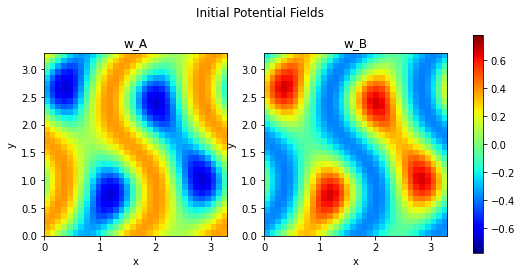

In [14]:
nx = params["nx"]
lx = params["lx"]

# Set initial fields
w_A = np.zeros(nx, dtype=np.float64)
w_B = np.zeros(nx, dtype=np.float64)
print("w_A and w_B are initialized to gyroid phase.")
# [Ref: https://pubs.acs.org/doi/pdf/10.1021/ma951138i]
for i in range(0,nx[0]):
    xx = (i+1)*2*np.pi/nx[0]
    for j in range(0,nx[1]):
        yy = (j+1)*2*np.pi/nx[1]
        zz = np.arange(1,nx[2]+1)*2*np.pi/nx[2]
        
        c1 = np.sqrt(8.0/3.0)*(np.cos(xx)*np.sin(yy)*np.sin(2.0*zz) +
            np.cos(yy)*np.sin(zz)*np.sin(2.0*xx)+np.cos(zz)*np.sin(xx)*np.sin(2.0*yy))
        c2 = np.sqrt(4.0/3.0)*(np.cos(2.0*xx)*np.cos(2.0*yy)+
            np.cos(2.0*yy)*np.cos(2.0*zz)+np.cos(2.0*zz)*np.cos(2.0*xx))
        w_A[i,j,:] = -0.3164*c1 +0.1074*c2
        w_B[i,j,:] =  0.3164*c1 -0.1074*c2

w = {"A": w_A, "B": w_B}  # potential field dictionary

# Plot each image with the same vmin and vmax
vmin = min(w_A.min(), w_B.min())
vmax = max(w_A.max(), w_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Initial Potential Fields")
im = axes[0].imshow(w_A[0,:,:], extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(w_B[0,:,:], extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='w_A', xlabel='x', ylabel='y')
axes[1].set(title='w_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 3. Initialization

One of eigenvalues is zero for given chiN values.
------------ Polymer Field Theory for Multimonomer ------------
Eigenvalues:
	 [-20.   0.]
Eigenvectors [v1, v2, ...] :
	 [[ 1.  1.]
	 [-1.  1.]]
Mapping matrix A:
	 [[ 1.  1.]
	 [-1.  1.]]
Real Fields:  [0]
Imaginary Fields:  [1]
In Hamiltonian:
	reference energy:  5.0
	coefficients of int of mu(r)/V:  [-0. -1.]
	coefficients of int of mu(r)^2/V:  [0.05 0.  ]
	dH_ref/dχN:  {'A,B': 0.24999999999053554}
	d(coef of mu(r))/dχN:  {'A,B': array([0., 0.])}
	d(coef of mu(r)^2)/dχN:  {'A,B': array([-0.0025,  0.    ])}
Monomer color:  {'A': 'red', 'B': 'blue'}
==================== MKL Version ====================
Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors
---------- Simulation Parameters ----------
Platform : cpu-mkl
Box Dimension: 3

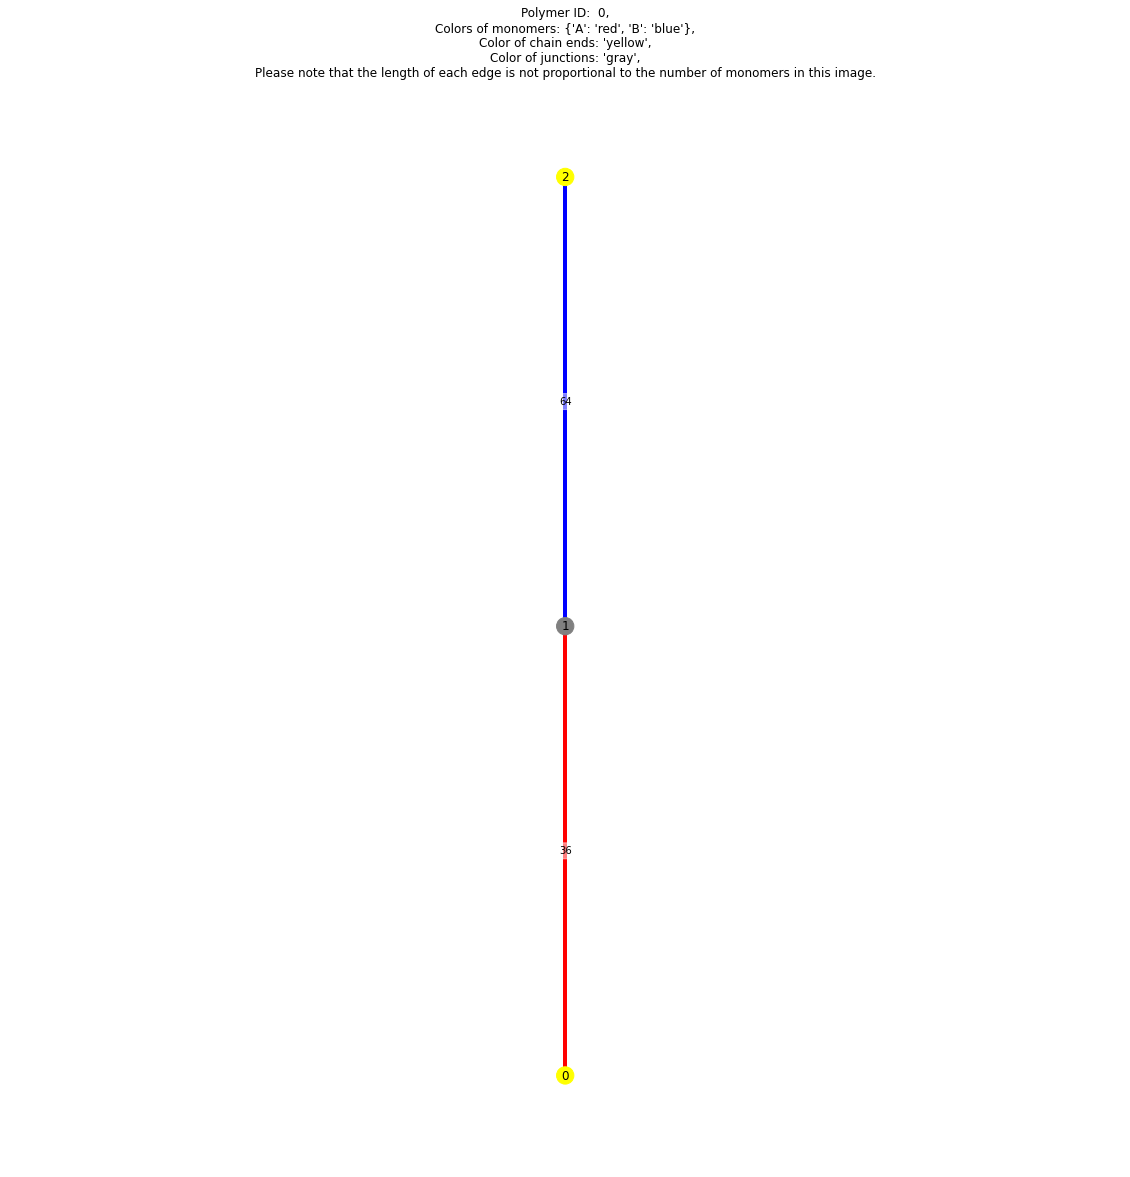

In [15]:
# Initialize calculation
calculation = scft.SCFT(params=params)

### 4. Run

In [16]:
# Run
calculation.run(initial_fields={"A": w_A, "B": w_B})

---------- Run ----------
iteration, mass error, total_partitions, energy_total, error_level, box size
       1    2.016E-15  [ 1.0111950E+00  ]    -0.005550595   1.4459112E+00  [  3.3000000, 3.3000000, 3.3000000 ]
       2   -2.365E-13  [ 1.0120871E+00  ]    -0.005274676   1.0819658E+00  [  3.3000217, 3.3000217, 3.3000217 ]
       3    5.201E-13  [ 1.0136595E+00  ]    -0.005598893   8.8631268E-01  [  3.3000287, 3.3000287, 3.3000287 ]
       4    1.866E-13  [ 1.0156725E+00  ]    -0.006242039   7.8452381E-01  [  3.3000282, 3.3000282, 3.3000282 ]
       5   -6.822E-14  [ 1.0180636E+00  ]    -0.007097169   7.3177360E-01  [  3.3000234, 3.3000234, 3.3000234 ]
       6    5.477E-13  [ 1.0208492E+00  ]    -0.008133890   7.0422113E-01  [  3.3000156, 3.3000156, 3.3000156 ]
       7    6.228E-14  [ 1.0240843E+00  ]    -0.009356138   6.8970776E-01  [  3.3000054, 3.3000054, 3.3000054 ]
       8    5.364E-13  [ 1.0278468E+00  ]    -0.010784757   6.8203435E-01  [  3.2999928, 3.2999928, 3.2999928 ]
 

### 5. Display the Results

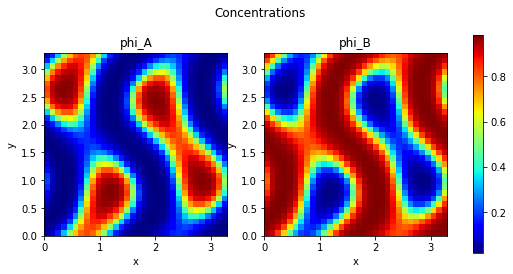

In [17]:
# Get the ensemble average concentration for each monomer type
phi_A = np.reshape(calculation.phi["A"], nx)
phi_B = np.reshape(calculation.phi["B"], nx)

# Plot each image with the same vmin and vmax
vmin = min(phi_A.min(), phi_B.min())
vmax = max(phi_A.max(), phi_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Concentrations")
im = axes[0].imshow(phi_A[0,:,:], extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(phi_B[0,:,:], extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='phi_A', xlabel='x', ylabel='y')
axes[1].set(title='phi_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()


### 6. Save the Results

In [18]:
# Save final results (.mat, .json or .yaml format)
calculation.save_results("fields.json")

# Recording first a few iteration results for debugging and refactoring
    #    1   -8.105E-15  [ 1.0111950E+00  ]    -0.005550595   1.4459112E+00  [  3.3000000, 3.3000000, 3.3000000 ]
    #    2   -5.329E-15  [ 1.0120871E+00  ]    -0.005274676   1.0819658E+00  [  3.3000217, 3.3000217, 3.3000217 ]
    #    3   -1.554E-15  [ 1.0136595E+00  ]    -0.005598893   8.8631268E-01  [  3.3000287, 3.3000287, 3.3000287 ]
    #    4   -8.660E-15  [ 1.0156725E+00  ]    -0.006242039   7.8452381E-01  [  3.3000282, 3.3000282, 3.3000282 ]
    #    5   -2.331E-15  [ 1.0180636E+00  ]    -0.007097169   7.3177360E-01  [  3.3000234, 3.3000234, 3.3000234 ]